- mamba install optuna 
- pip install optuna-integration[lightgbm]

c:\Users\JBarker\AppData\Local\miniforge3\envs\isr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


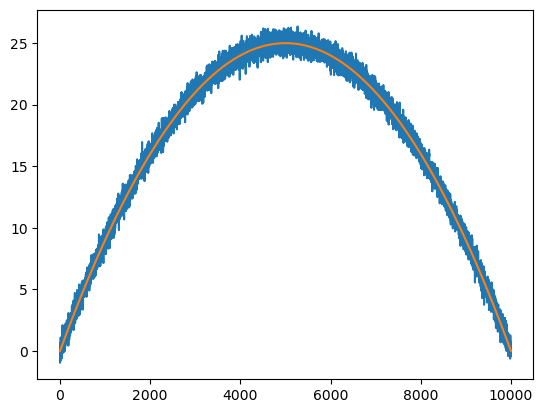

In [ ]:
from datetime import datetime
import pandas as pd 
import numpy as np
import seaborn as sns
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import shap

import warnings
warnings.filterwarnings('ignore')

rng = np.random.default_rng(seed=42)
num_rows = 10_000

binary = rng.binomial(n=1, p=0.5, size=num_rows)

line = np.linspace(0, 10, num_rows)
noise = rng.normal(loc=0, scale=.5, size=num_rows)
parabola = 10*line - line**2
noisy_parabola = parabola + noise 

# sns.lineplot(noisy_parabola*(binary+.5))
sns.lineplot(noisy_parabola)
sns.lineplot(parabola)
# plt.show()
X_train, X_valid, y_train, y_valid = train_test_split(np.vstack([noisy_parabola, noise, line]).T, parabola, test_size=0.2, random_state=42)

In [2]:
def objective(trial):    
    # Define the hyperparameter search space
    param = {
        'random_state': 42,
        'early_stopping_rounds': 50, # the {n}th accuracy on the validation set does not improve, stop training
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',

        # bagging_fraction is like feature_fraction, but randomly selects data without resampling
        # bagging_freq must be non-zero to enable bagging
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 20),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),

        # max number of bins that feature values will be bucketed in
        # 'max_bin': trial.suggest_int('max_bin', 1, 1000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 1000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf ', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 10, 15000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # Initialize the model with these parameters
    model = lgb.train(
        params=param,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train_0', 'valid_0'],
        callbacks=[
            LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
            lgb.log_evaluation(-1)                   # Suppress training logs
        ]
    )
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))    
    return rmse


# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
# study_name = datetime.now().strftime("%Y-%m-%d_%H-%M")
# storage_name = f"sqlite:///{os.path.join(optuna_dir, study_name)}.db"
# study = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize')
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
study.best_params

[I 2025-02-07 15:26:18,988] A new study created in memory with name: no-name-b6146d4d-7942-4245-b2eb-c78d07c814fb
[I 2025-02-07 15:26:19,963] Trial 0 finished with value: 0.06661458426519798 and parameters: {'bagging_fraction': 0.9675212378442133, 'bagging_freq': 7, 'cat_l2': 11.025168333975984, 'extra_trees': False, 'feature_fraction': 0.8705511180176377, 'colsample_bytree': 0.31215356458663446, 'learning_rate': 0.013643865853330482, 'max_depth': 239, 'min_samples_leaf ': 30, 'n_estimators': 3425, 'num_leaves': 236, 'lambda_l1': 1.2176844660591462e-05, 'lambda_l2': 0.6446000799339123, 'subsample': 0.2304823698529498}. Best is trial 0 with value: 0.06661458426519798.
[I 2025-02-07 15:26:20,758] Trial 1 finished with value: 0.19218612407409008 and parameters: {'bagging_fraction': 0.7513572822894463, 'bagging_freq': 5, 'cat_l2': 17.263557293323313, 'extra_trees': True, 'feature_fraction': 0.5993440012814462, 'colsample_bytree': 0.3148297343553499, 'learning_rate': 0.036754637619134424, '

{'bagging_fraction': 0.9751456135298038,
 'bagging_freq': 6,
 'cat_l2': 15.026039999227262,
 'extra_trees': False,
 'feature_fraction': 0.5544796438975631,
 'colsample_bytree': 0.28309228445024515,
 'learning_rate': 0.04391275556436935,
 'max_depth': 325,
 'min_samples_leaf ': 20,
 'n_estimators': 657,
 'num_leaves': 65,
 'lambda_l1': 3.4496641059863465e-06,
 'lambda_l2': 0.276544307440762,
 'subsample': 0.20881335902473447}

In [3]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
model = lgb.train(
    params=study.best_params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train_0', 'valid_0'],
)
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)


<Axes: >

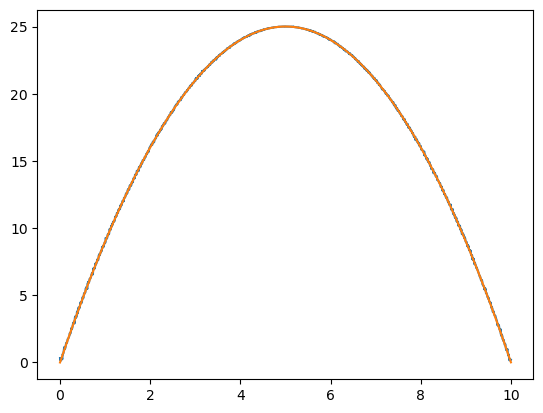

In [4]:
sns.lineplot(x=X_valid[:, 2], y=y_pred)
sns.lineplot(x=X_valid[:, 2], y=y_valid)

In [11]:
shap.initjs()

explainer = shap.TreeExplainer(model)
explanation = explainer(X_valid)

shap_values = explanation.values

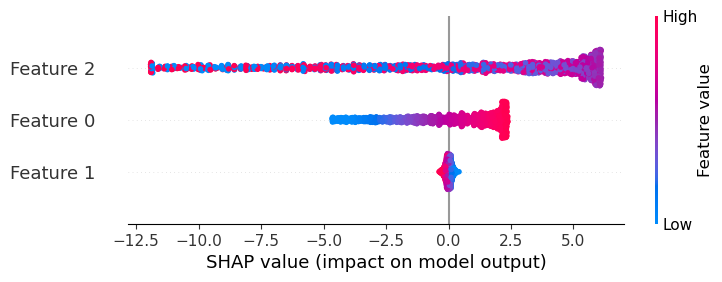

In [12]:
shap.plots.beeswarm(explanation)

In [13]:
# visualize the first prediction's explanation
shap.plots.force(explainer.expected_value, shap_values[0, ...])